<h1>Relax Take-Home Challenge</h1>

<h2>Context and Data Notes</h2>

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. 

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
<li>name: the user's name
<li>object_id: the user's id
<li>email: email address
<li>creation_source: how their account was created. This takes on one of 5 values: <br />
     -PERSONAL_PROJECTS: invited to join another user's personal workspace <br    />
    -GUEST_INVITE: invited to an organization as a guest (limited permissions) <br />
    -ORG_INVITE: invited to an organization (as a full member) <br />
    -SIGNUP: signed up via the website <br />
    -SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) <br />
<li>creation_time: when they created their account
<li>last_session_creation_time: unix timestamp of last login
<li>opted_in_to_mailing_list: whether they have opted into receiving marketing emails
<li>enabled_for_marketing_drip: whether they are on the regular
marketing email drip
<li>org_id: the organization (group of users) they belong to
<li>invited_by_user_id: which user invited them to join (if applicable).
<br /><br />
2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, **identify which factors predict future user adoption**.
<br /><br />
We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better - no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

<h2>Exploratory Data Analysis</h2>


<h4>Import User and Engagement Data</h4>

In [2]:
users_df = pd.read_csv("takehome_users.csv")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
eng_df = pd.read_csv("takehome_user_engagement.csv")
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
eng_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [6]:
eng_df['time_stamp'] = eng_df['time_stamp'].astype('datetime64[ns]').dt.date
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Let's make sure that some of variables introduced in the introduction are as described:

In [7]:
users_df['creation_source'].unique()
print("Creation Source Unique Values: {}".format(users_df['creation_source'].unique()))
print('Creation Source\'s Unique Values are as described.')

print('\n')
print("Number of days in data where user shown as logged in more than 1 times: {}".format(eng_df[['time_stamp', 'user_id']].duplicated().sum()))
print('Daily log data is as described.')

Creation Source Unique Values: ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']
Creation Source's Unique Values are as described.


Number of days in data where user shown as logged in more than 1 times: 0
Daily log data is as described.


<h4>Create Adoption Variable [Target]</h4>
**Observe total user daily log numbers before creating the adoption variable**

In [8]:
_daily_logs = eng_df[['time_stamp', 'user_id']].groupby(by=['user_id']).count().reset_index()
_daily_logs = _daily_logs.groupby(by=['time_stamp']).count().reset_index()
_daily_logs.rename(columns = {'time_stamp':'total_logs', 'user_id':'count'}, inplace=True)
_daily_logs.head(20)


,total_logs,count
0,1,6235
1,2,340
2,3,241
3,4,181
4,5,110
5,6,85
6,7,68
7,8,57
8,9,48
9,10,34


**Create the adoption variable [Target]**<br />
Adopted user is defined as "user who has logged into the product on three separate days in at least one seven-day period"
Let's find out the adopted users:

In [9]:
def is_adopted(sr, sep_days=3, over_days=7):
    """Figure out which users adopted the product. Adoption is True if the service was used sep_days times in an over_days period"""
    sr = pd.to_datetime(sr)
    sr = sr.sort_values(ascending=True)
    sr = sr.diff().dt.days.astype(float)
    sr.iloc[0] = 0
    #print(sr)
    sr = sr.rolling(window=sep_days-1).sum()
    #print(sr)
    _ = sr < over_days-1
    return _.any()
# _daily_logs = eng_df[['time_stamp', 'user_id']].groupby(by=['user_id']).count().reset_index()
# print(_daily_logs.sort_values(by=['time_stamp'], ascending=False))
# user_filter = eng_df['user_id']==2
# sr = eng_df[user_filter]['time_stamp']
# print(sr)

adopted_df = eng_df[['time_stamp', 'user_id']].groupby(['user_id']).agg(is_adopted).reset_index()
adopted_df.rename(columns = {'time_stamp':'isAdopted'}, inplace=True)
adopted_df[adopted_df['isAdopted']==True].head()



,user_id,isAdopted
1,2,True
7,10,True
12,19,True
13,20,True
18,25,True


**Merge Adoption Status with Users**<br />


In [10]:
df = pd.merge(left= users_df, right = adopted_df, left_on=['object_id'], right_on=['user_id'], how='left')
#Map isAdopted: Adopted User = 1, NonAdopted User = 0, NonAdopted and Never Logged = -1
adopted_dict = {True:1, False:0, np.nan:-1}
df['isAdopted'] = df['isAdopted'].map(lambda x: adopted_dict[x])


df['isAdopted'].value_counts()

 0    7008
-1    3177
 1    1815
Name: isAdopted, dtype: int64

<h4>Explore Variables In Users</h4>

**Explore: Adoption by Creation Source**<br />

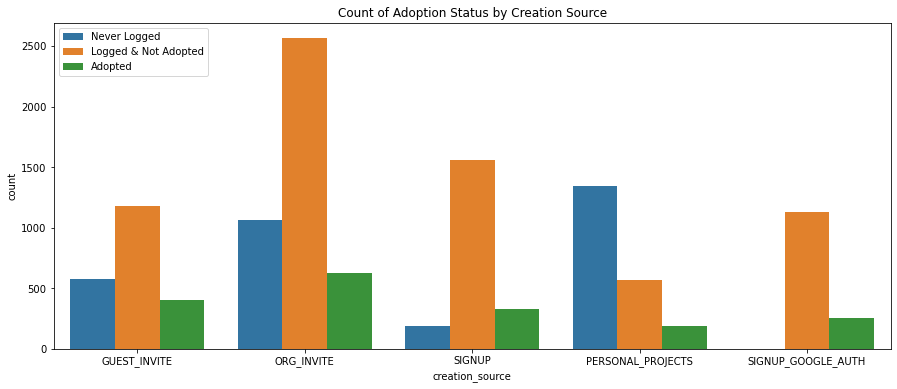

creation_source  GUEST_INVITE  ORG_INVITE  PERSONAL_PROJECTS    SIGNUP  \
isAdopted                                                                
-1                   0.265834    0.250588           0.638086  0.090561   
 0                   0.545539    0.602727           0.270962  0.749401   
 1                   0.188627    0.146685           0.090952  0.160038   

creation_source  SIGNUP_GOOGLE_AUTH  
isAdopted                            
-1                          0.00000  
 0                          0.81444  
 1                          0.18556  

RC Table:
 [[ 408.  624.  192.  334.  257.]
 [1755. 3630. 1919. 1753. 1128.]]

Chi2 value: 97.973
p-value: 0.00000
dof: 4
Can reject at 95% confidence the null hypothesis that the adoption rates are equal.


In [11]:
sns.countplot(data=df, x = 'creation_source', hue='isAdopted', dodge=True)
a_by_creation = pd.pivot_table(data = df, index='isAdopted', columns='creation_source', aggfunc='count').replace({np.nan:0})['creation_time']
a_by_creation_rate = a_by_creation/(a_by_creation.sum())
ax = plt.gca()
plt.gca().set_title('Count of Adoption Status by Creation Source')
ax.legend(labels=['Never Logged','Logged & Not Adopted','Adopted'])
plt.gcf().set_size_inches(15,6)
plt.show()
print(a_by_creation_rate)


_rc_creation_source = np.vstack([a_by_creation.loc[1,:].values, a_by_creation.loc[-1:0,:].sum().values])
print('\nRC Table:\n {0}\n'.format(_rc_creation_source))
_chi2, _p, _dof, _ex = chi2_contingency(_rc_creation_source)
print('Chi2 value: {0:2.3f}\np-value: {1:1.5f}\ndof: {2:d}'.format(_chi2, _p, _dof))
print('Can reject at 95% confidence the null hypothesis that the adoption rates are equal.')

**Two points stand out:**
<li>Adoption status is nearly constant across creation_source except from those people pulled in for personal porjects - which is lower at around 9% vs the 14-18% rangec compared to other methodologies. (we can reject the equality across methodologies)
<li>Logins from people being pulled in also has the highest Never-Logged rate.
  
    
<br/>    Initial Thoughts: Relatively it may not make sense to move forward across this channel.


**Explore: Adoption by Opting-In to Mailing List**<br />

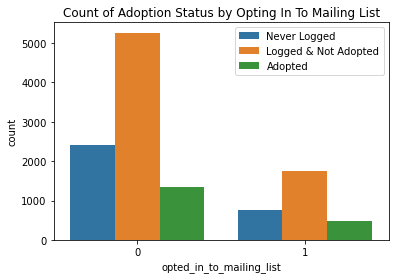

opted_in_to_mailing_list         0         1
isAdopted                                   
-1                        0.267488  0.256513
 0                        0.584277  0.583166
 1                        0.148235  0.160321
Chi2 value: 2.464
p-value: 0.11652
Cannot reject at 95% confidence the null hypothesis that the rates are equal.


In [12]:
sns.countplot(data=df, x = 'opted_in_to_mailing_list', hue='isAdopted')
a_by_opted_in = pd.pivot_table(data = df, index='isAdopted', columns='opted_in_to_mailing_list', aggfunc='count').replace({np.nan:0})['creation_time']
a_by_opted_in_rate = a_by_opted_in/(a_by_opted_in.sum())
ax = plt.gca()
plt.gca().set_title('Count of Adoption Status by Opting In To Mailing List')
ax.legend(labels=['Never Logged','Logged & Not Adopted','Adopted'])
plt.show()
print(a_by_opted_in_rate)

_rc_opted_in = np.vstack([a_by_opted_in.loc[1,:].values, a_by_opted_in.loc[-1:0,:].sum().values])
#print(_rc_opted_in)
_chi2, _p, _dof, _ex = chi2_contingency(_rc_opted_in)
print('Chi2 value: {0:2.3f}\np-value: {1:1.5f}'.format(_chi2, _p))
print('Cannot reject at 95% confidence the null hypothesis that the rates are equal.')


We do not see a reasonable difference between the rates of adoption across opting-in status.

enabled_for_marketing_drip         0         1
isAdopted                                     
-1                          0.267045  0.251674
 0                          0.583366  0.587612
 1                          0.149589  0.160714
Chi2 value: 1.384
p-value: 0.23934
Cannot reject at 95% confidence the null hypothesis that the rates are equal.


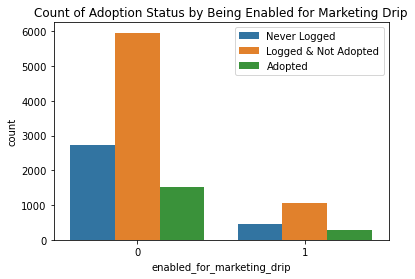

In [13]:
sns.countplot(data=df, x = 'enabled_for_marketing_drip', hue='isAdopted')
a_by_drip = pd.pivot_table(data = df, index='isAdopted', columns='enabled_for_marketing_drip', aggfunc='count').replace({np.nan:0})['creation_time']
a_by_drip_rate = a_by_drip/(a_by_drip.sum())
print(a_by_drip_rate)
ax = plt.gca()
plt.gca().set_title('Count of Adoption Status by Being Enabled for Marketing Drip')
ax.legend(labels=['Never Logged','Logged & Not Adopted','Adopted'])

_rc_drip = np.vstack([a_by_drip.loc[1,:].values, a_by_drip.loc[-1:0,:].sum().values])
#print(_rc_drip)
_chi2, _p, _dof, _ex = chi2_contingency(_rc_drip)
print('Chi2 value: {0:2.3f}\np-value: {1:1.5f}'.format(_chi2, _p))
print('Cannot reject at 95% confidence the null hypothesis that the rates are equal.')

For the whole dataset and the whole period, we do not see a difference in adoption rate across enabling by marketing drip.

isAdopted        -1         0         1
org_id                                 
387        0.083333  0.333333  0.583333
381        0.250000  0.250000  0.500000
235        0.230769  0.307692  0.461538
395        0.222222  0.333333  0.444444
270        0.071429  0.500000  0.428571
...             ...       ...       ...
299        0.055556  0.944444  0.000000
329        0.461538  0.538462  0.000000
346        0.166667  0.833333  0.000000
355        0.222222  0.777778  0.000000
416        0.000000  1.000000  0.000000

[417 rows x 3 columns]


Text(0.5, 0, 'Adoption Rate')

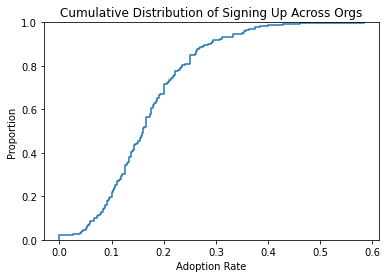

In [14]:
a_by_org_id = pd.pivot_table(data = df, index='isAdopted', columns='org_id', aggfunc='count').replace({np.nan:0})['creation_time']
a_by_org_id_rate = (a_by_org_id/(a_by_org_id.sum())).T.sort_values(by=1, ascending=False)
print(a_by_org_id_rate)
sns.ecdfplot(data = a_by_org_id_rate, x = 1)
ax = plt.gca()
ax.set_title('Cumulative Distribution of Signing Up Across Orgs')
ax.set_xlabel('Adoption Rate')

Approximately, 10% of the organizations have an adoption rate more than 0.3. Perhaps, it will make sense to take a look at those organizations and how they are different than the remaining 90%. 

In [15]:
a_top_40_orgs = a_by_org_id_rate.iloc[:40, 2].index.values
print(a_top_40_orgs)

[387 381 235 395 270 318 352 399 161 400 392 415 117 364 345 388 289 225
 231 282 291 343 281  82 218 295 306 139 177 193 372  62 305 304 366 280
 238 273 141 296]


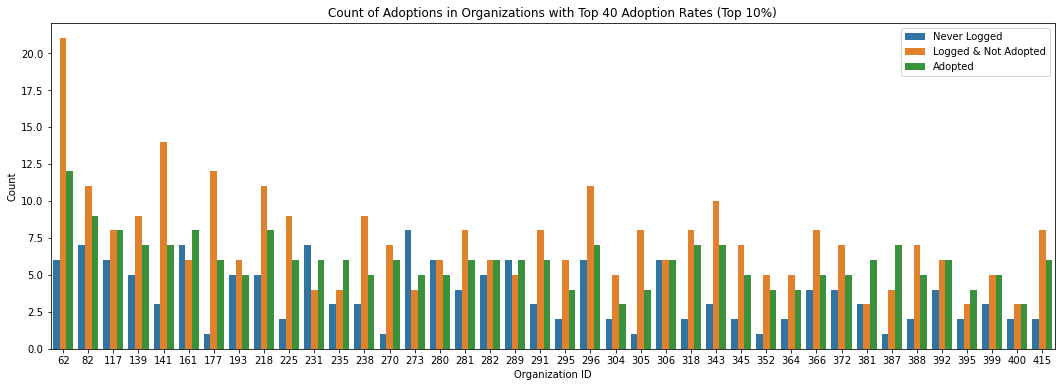

In [16]:
sns.countplot(data = df[df['org_id'].isin(a_top_40_orgs)], x='org_id', hue='isAdopted',)
plt.gcf().set_size_inches(18,6)
ax = plt.gca()
ax.set_title('Count of Adoptions in Organizations with Top 40 Adoption Rates (Top 10%)')
ax.set_xlabel('Organization ID')
ax.set_ylabel('Count')
ax.legend(labels=['Never Logged','Logged & Not Adopted','Adopted']);

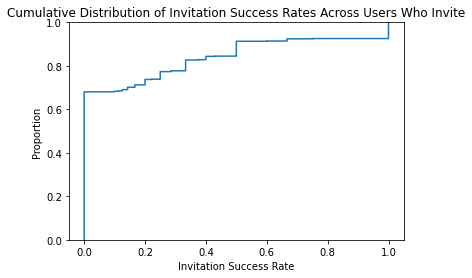

isAdopted                 -1         0    1
invited_by_user_id                         
7071.0              0.000000  0.000000  1.0
6682.0              0.000000  0.000000  1.0
5875.0              0.000000  0.000000  1.0
2271.0              0.000000  0.000000  1.0
7735.0              0.000000  0.000000  1.0
...                      ...       ...  ...
4662.0              0.000000  1.000000  0.0
4655.0              1.000000  0.000000  0.0
4654.0              0.000000  1.000000  0.0
4652.0              0.000000  1.000000  0.0
11999.0             0.285714  0.714286  0.0

[2564 rows x 3 columns]


In [17]:
a_by_inv_id = pd.pivot_table(data = df, index='isAdopted', columns='invited_by_user_id', aggfunc='count').replace({np.nan:0})['creation_time']
a_by_inv_id_rate = (a_by_inv_id/(a_by_inv_id.sum())).T.sort_values(by=1, ascending=False)
sns.ecdfplot(data = a_by_inv_id_rate, x = 1)
plt.gca().set_title('Cumulative Distribution of Invitation Success Rates Across Users Who Invite')
plt.gca().set_xlabel('Invitation Success Rate');
plt.show()
print(a_by_inv_id_rate)

Looks like the top 10% people who invite have more than 50% invitation success rate.

<h2>Where Are We?</h2>

Up to this point, I was not able to pinpoint any major factors that impact the adoption rate more than the other however we still made some observations and progress.

  I have seen the variables from the user dataframe do not have a great predictive power on the user adoption (based on the definition given in text) by themselves. Some observations that I can make are i) Personal Projects may not be the best way to gain users ii) 10% of companies have a larger than 0.30 rate of adoption iii) there are a set of people who invite others that have an approximately 50% rate of success. Besides, expanding upon the last two paths, I believe I should make better use of the time-based engagement data provided to me.

<h2>Where to Go from Here?</h2>

<h4>1) Further Exploration: Making Better Use of Engagement/Login (Time-based) Data

What this analysis seems to miss is capturing the dynamics of events - both on a per person and per organization basis.

<li>On a per person basis, one could use the creation_time of a users account as a normalizing point for all users and proceed ask some conditional questions across people cross-sectionally. Questions such as:    <br />
    
--What is the probability (looking from creation_date) that a person will adopt conditional on the fact that there were 1 {2, or 3 or more} people already adopted across the organization? If the person eventually adopts, what is the average number of days? And does this number change if there were more people signed up at the organization?   If we see some sort of a network effect here, we could make efforts to accelerate the network effect. 

--What has been the average number of logins (or logins per week) per person before they adopted? This sum/average could be compared to the group that didn't adopt. At the end of the day, if the difference is meaningful, one could imagine an A/B test to increase the logins in the population (taking care not to alienate people)   
--What is the probability of adoption conditional on the person being close to adoption before (defined by logging say 2 times per week)? Then, one could run an A/B test on that population to see if the conversion probability will move up.

<h4>2) A Modelling Path - Ensemble Models / Logistic Regression

A logistic regression or an ensemble model could be used incorporating a some more extra features (perhaps some of the ones used above) to give us the feature importances associated with each of those factors. Results of those importances could be further used to guide the company to generate better hypothesis regarding what might positively improve adoption. 